<a href="https://colab.research.google.com/github/himanshu1311/lake_depth_classification/blob/main/lakeDepthClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Libraries**

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy import stats
import pylab as pl
from scipy import stats
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier


# Display HTML
from IPython.core.display import display, HTML

## 1.**Load Data**

In [3]:
data =  pd.read_csv('/content/drive/MyDrive/glacierMLproject/filtered_dataset.csv')

In [4]:
data.head()

,maxdepth,elevation_m,lake_area_m2,B2,B3,B4,B5,B6,B7,B10,B11
0,2.7,295.855011,1.149470e+06,16597.0,16121.0,16394.0,18612.0,10161.0,9475.0,16645.0,16034.0
1,6.1,447.834992,2.486590e+05,16579.0,16064.5,16735.0,14769.0,7555.0,7122.5,16327.5,15853.5
2,1.8,295.855011,7.541100e+05,16940.0,16517.0,17100.0,18278.0,7890.0,7446.0,16776.0,16226.0
3,5.2,4.256000,9.255881e+04,8894.0,7476.0,6924.0,6214.0,5313.0,5240.0,21881.0,19937.0
4,3.4,13.650001,1.399848e+05,8725.0,7383.0,6680.0,6530.0,5479.0,5368.0,21753.0,19916.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9563 entries, 0 to 9562
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   maxdepth      9563 non-null   float64
 1   elevation_m   9563 non-null   float64
 2   lake_area_m2  9563 non-null   float64
 3   B2            9563 non-null   float64
 4   B3            9563 non-null   float64
 5   B4            9563 non-null   float64
 6   B5            9563 non-null   float64
 7   B6            9563 non-null   float64
 8   B7            9563 non-null   float64
 9   B10           9563 non-null   float64
 10  B11           9563 non-null   float64
dtypes: float64(11)
memory usage: 821.9 KB


In [6]:
data.describe()

,maxdepth,elevation_m,lake_area_m2,B2,B3,B4,B5,B6,B7,B10,B11
count,9563.000000,9563.000000,9.563000e+03,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000,9563.000000
mean,10.507768,314.552839,2.715774e+06,13173.923821,12176.577277,12057.902541,13997.346544,7754.014640,7252.098662,17844.085904,16916.789397
std,9.438927,141.454898,2.492843e+07,2633.599519,2641.122341,3030.985872,3465.293024,1587.210939,1096.522071,2486.560117,2108.069125
min,0.100000,0.000000,1.007998e+04,8513.000000,7075.000000,6280.000000,5867.000000,5253.500000,5145.000000,0.000000,0.000000
25%,4.572000,232.811470,1.659734e+05,11055.500000,10091.000000,9640.000000,11733.000000,6767.500000,6570.000000,16636.000000,15921.750000
50%,8.229600,316.089996,4.614951e+05,13015.000000,12016.000000,11910.000000,14098.000000,7353.000000,7182.000000,17886.500000,17002.000000
75%,13.700000,412.296997,1.214870e+06,14973.250000,13951.250000,14124.500000,16363.500000,8242.250000,7729.000000,19271.750000,18088.000000
max,198.400000,1038.649048,1.237798e+09,26576.000000,25210.500000,25333.000000,30224.000000,16561.000000,13984.500000,25312.500000,23188.500000


In [7]:
## Band and elevation constraints
data=data[data['elevation_m']>0]
data=data[data['B10']>0]
data=data[data['B11']>0]

In [8]:
## Remove outliers using 3-sigma rule
z_scores = stats.zscore(data[['maxdepth','elevation_m','lake_area_m2','B2','B3','B4','B5','B6','B7','B10','B11']])

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores <3).all(axis=1)
data = data[filtered_entries]

In [9]:
## Categorize the max depth into y labels
data.loc[(data['maxdepth'] <= 15) & (data['maxdepth'] >0), 'target'] = 0
data.loc[(data['maxdepth'] >15), 'target'] = 1

In [10]:
data['target'].describe()

count    9042.000000
mean        0.197523
std         0.398152
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: target, dtype: float64

## 2.**Visualization**

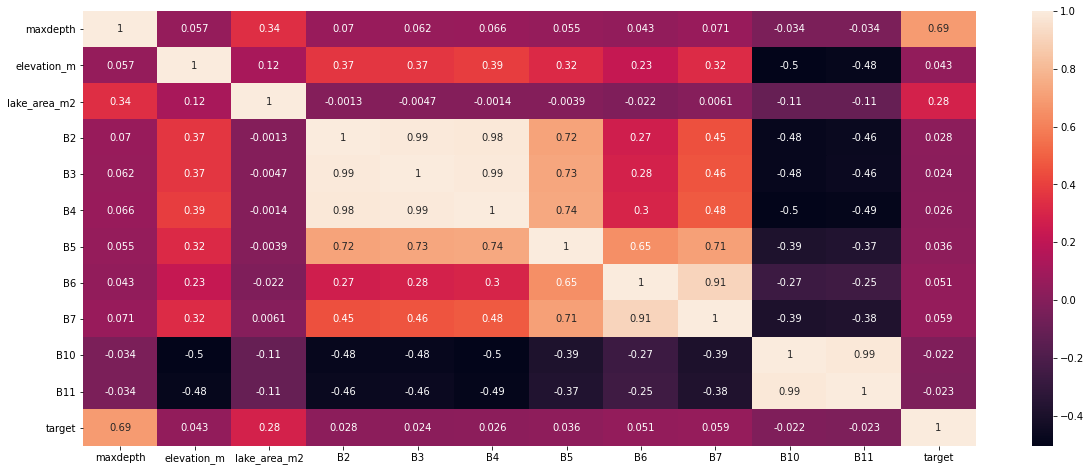

In [11]:
## Corrleation heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(data.corr(method='spearman'), annot = True)

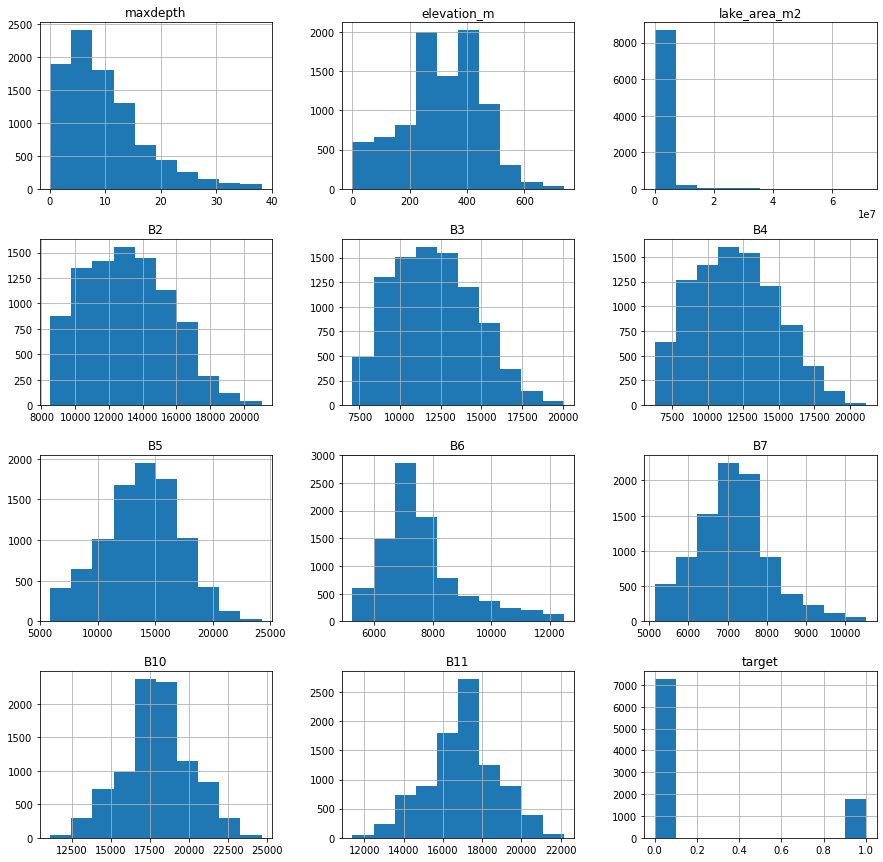

In [12]:
data.hist(figsize=(15,15))
plt.show()

## 3. **Prepare Train and Test Data**

In [13]:
## Feature Selection
data1 = data
data1 = data.drop(['B3','B4','B7','B11'], axis = 1)

In [14]:
X = data1.iloc[:, 1:-1].values    #   X -> Feature Variables
y = data1.iloc[:, -1].values #   y ->  Target

In [15]:
## Data split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 16, stratify=y)

In [16]:
## Standard scale the data points
scalerX = StandardScaler().fit(X_train)
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test)

In [17]:
## LGBM Model
Model = LGBMClassifier(
    # objective='multiclass',
    boosting='gbdt',
    learning_rate = 0.01,
    max_depth = 8,
    num_leaves = 10,
    max_bin = 512,
    feature_fraction = 0.8,
    n_estimators = 3000,
    bagging_fraction = 0.9,
    reg_alpha = 2.5,
    reg_lambda = 2.5)

Model.fit(X_train, y_train)


LGBMClassifier(bagging_fraction=0.9, boosting='gbdt', boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
               importance_type='split', learning_rate=0.01, max_bin=512,
               max_depth=8, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=3000, n_jobs=-1, num_leaves=10,
               objective=None, random_state=None, reg_alpha=2.5, reg_lambda=2.5,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [20]:
## Result
y_pred=Model.predict(X_test)
train_pred = Model.predict(X_train)

cf_matrix = confusion_matrix(y_pred,y_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_pred,y_test))

# Accuracy Score
print('Test accuracy is ',accuracy_score(y_pred,y_test))
print('Train accuracy is ',accuracy_score(train_pred,y_train))

              precision    recall  f1-score   support

         0.0       0.83      0.97      0.89      1452
         1.0       0.59      0.18      0.27       357

    accuracy                           0.81      1809
   macro avg       0.71      0.57      0.58      1809
weighted avg       0.78      0.81      0.77      1809

[[1407  293]
 [  45   64]]
Test accuracy is  0.8131564400221116
Train accuracy is  0.8441863680353934


# **Plot**

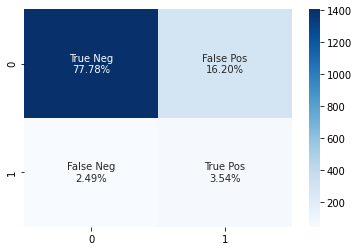

In [26]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
# group_counts = [“{0:0.0f}”.format(value) for value in
#                 cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')